In [1]:
import cv2
import tensorflow as tf
import os
import imghdr
import numpy as np
from matplotlib import pyplot as plt

Found 2070 files belonging to 2 classes.


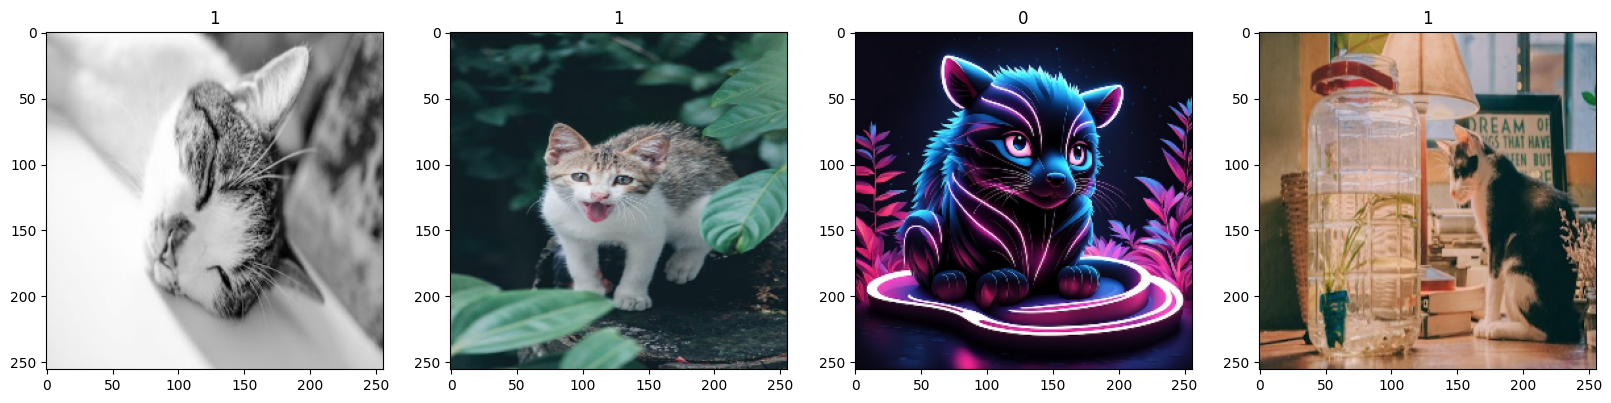

In [2]:
data = tf.keras.utils.image_dataset_from_directory('data')

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [3]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7) # training set will be 70% of data
val_size = int(len(data)*.2) # validation set size will be 20% of data
test_size = int(len(data)*.1) # test size will be 10%

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [4]:
from keras.models import Sequential # import sequential API. Sequential is good for 1 data input.
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout # import needed layers


model = Sequential() # create a model with sequential class

# Layers are added sequentialy
# 1st layer: convolution has 16 filters ( 3 x 3 pixels inside).
# The power is coming from activation function. Relu is replacing null values.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# 2nd layer - choose maximum value after the relu activation (2 x 2)
model.add(MaxPooling2D())
# 3rd layer, output is only 1 value, use 32 filters
model.add(Conv2D(32, (3,3), 1, activation='relu'))
# 4th layer
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# flatten the data again down
model.add(Flatten())
# convolution has 2 Dense layers
model.add(Dense(256, activation='relu')) # output is 256 values
# The final sigmoid layer, close to 0 are mountains, close to 1 is the city
# Sigmoid activation is non-linear, continuously differentiable, monotonic, and has a fixed output range. Main advantage is simple and good for classifier.
# Sigmoid activation gives rise to a problem of “vanishing gradients” because Its output isn’t zero centered. Sigmoid activation is computationaly more expensive.
model.add(Dense(1, activation='sigmoid')) # single dense layer is the final layer, converts values between 0 and 1


model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# model.summary()
# if the layer is not trainable, there is 0 in Param column
# total params stands for the total size of our model

In [6]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=5,restore_best_weights=True)
hist= model.fit(train, epochs=25, validation_data=val,callbacks=[earlystopping])

hist.history

Epoch 1/25
45/45 [==============================] - 19s 400ms/step - loss: 0.4620 - accuracy: 0.7833 - val_loss: 0.3083 - val_accuracy: 0.8894
Epoch 2/25
45/45 [==============================] - 19s 406ms/step - loss: 0.3252 - accuracy: 0.8722 - val_loss: 0.3088 - val_accuracy: 0.8918
Epoch 3/25
45/45 [==============================] - 20s 419ms/step - loss: 0.2304 - accuracy: 0.9167 - val_loss: 0.2831 - val_accuracy: 0.9087
Epoch 4/25
45/45 [==============================] - 19s 393ms/step - loss: 0.1683 - accuracy: 0.9299 - val_loss: 0.2008 - val_accuracy: 0.9279
Epoch 5/25
45/45 [==============================] - 19s 412ms/step - loss: 0.1573 - accuracy: 0.9403 - val_loss: 0.3920 - val_accuracy: 0.8558
Epoch 6/25
45/45 [==============================] - 20s 405ms/step - loss: 0.1475 - accuracy: 0.9465 - val_loss: 0.3056 - val_accuracy: 0.9038
Epoch 7/25
45/45 [==============================] - 19s 402ms/step - loss: 0.1021 - accuracy: 0.9639 - val_loss: 0.3263 - val_accuracy: 0.9159

{'loss': [0.4619651436805725,
  0.3251757025718689,
  0.23038268089294434,
  0.1683434247970581,
  0.15726949274539948,
  0.1475241631269455,
  0.10209881514310837,
  0.08529837429523468,
  0.06199201941490173,
  0.02589992620050907,
  0.04524674266576767,
  0.03224816545844078,
  0.011966053396463394,
  0.008614249527454376],
 'accuracy': [0.7833333611488342,
  0.8722222447395325,
  0.9166666865348816,
  0.9298611283302307,
  0.9402777552604675,
  0.9465277791023254,
  0.9638888835906982,
  0.9701389074325562,
  0.980555534362793,
  0.9923611283302307,
  0.9854166507720947,
  0.9895833134651184,
  0.9965277910232544,
  0.9958333373069763],
 'val_loss': [0.30833113193511963,
  0.30884402990341187,
  0.2830849289894104,
  0.2007669359445572,
  0.3919858932495117,
  0.3055720031261444,
  0.3262902796268463,
  0.3060261607170105,
  0.17471644282341003,
  0.25972726941108704,
  0.1973545253276825,
  0.18338251113891602,
  0.2682432532310486,
  0.2984425723552704],
 'val_accuracy': [0.88942

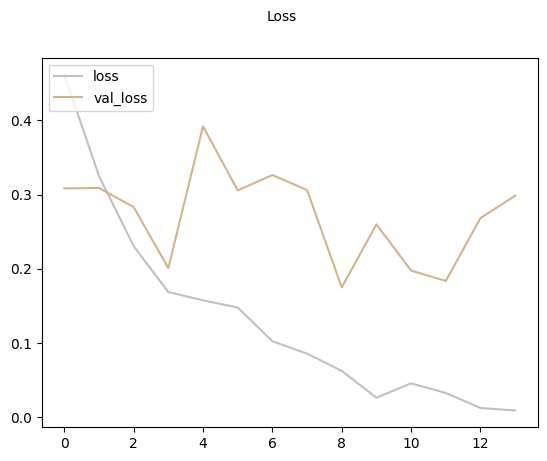

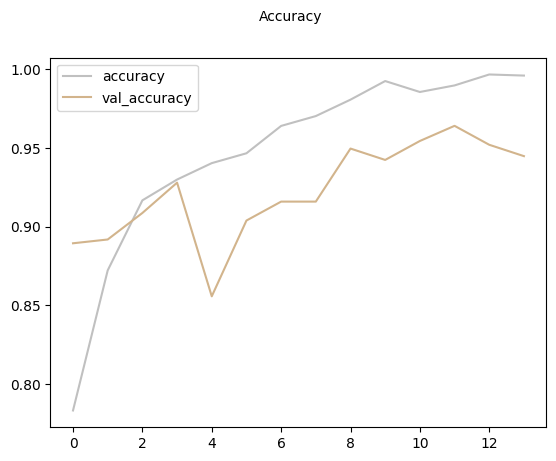

In [7]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='silver', label='loss')
plt.plot(hist.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()


fig = plt.figure()
plt.plot(hist.history['accuracy'], color='silver', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

In [8]:
from keras.layers import Dropout
from keras.regularizers import l2

model1 = Sequential()
model1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.01)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Conv2D(16, (3,3), 1, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [9]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist1 = model1.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping])
hist1.history

Epoch 1/50
45/45 [==============================] - 18s 281ms/step - loss: 2.4720 - accuracy: 0.5701 - val_loss: 1.1665 - val_accuracy: 0.8053
Epoch 2/50
45/45 [==============================] - 13s 282ms/step - loss: 0.9480 - accuracy: 0.7250 - val_loss: 0.9222 - val_accuracy: 0.7957
Epoch 3/50
45/45 [==============================] - 16s 348ms/step - loss: 0.8090 - accuracy: 0.7910 - val_loss: 0.7701 - val_accuracy: 0.8558
Epoch 4/50
45/45 [==============================] - 14s 284ms/step - loss: 0.6920 - accuracy: 0.8549 - val_loss: 0.6794 - val_accuracy: 0.8606
Epoch 5/50
45/45 [==============================] - 15s 311ms/step - loss: 0.6510 - accuracy: 0.8556 - val_loss: 0.6238 - val_accuracy: 0.8654
Epoch 6/50
45/45 [==============================] - 19s 406ms/step - loss: 0.6567 - accuracy: 0.8375 - val_loss: 0.6117 - val_accuracy: 0.8582
Epoch 7/50
45/45 [==============================] - 14s 285ms/step - loss: 0.5856 - accuracy: 0.8569 - val_loss: 0.5623 - val_accuracy: 0.8798

{'loss': [2.4719579219818115,
  0.9479815363883972,
  0.8089830279350281,
  0.6919826865196228,
  0.6509755849838257,
  0.6566706895828247,
  0.5855617523193359,
  0.5832974314689636,
  0.5906245708465576,
  0.520919144153595,
  0.5056089162826538,
  0.49762022495269775,
  0.4903751015663147,
  0.4752587080001831],
 'accuracy': [0.5701388716697693,
  0.7250000238418579,
  0.7909722328186035,
  0.8548611402511597,
  0.855555534362793,
  0.8374999761581421,
  0.8569444417953491,
  0.8569444417953491,
  0.8486111164093018,
  0.875,
  0.875,
  0.8791666626930237,
  0.8819444179534912,
  0.8791666626930237],
 'val_loss': [1.1664687395095825,
  0.9221827983856201,
  0.7701243162155151,
  0.6793526411056519,
  0.6238192915916443,
  0.6116568446159363,
  0.5623246431350708,
  0.5775824189186096,
  0.5757507681846619,
  0.5383848547935486,
  0.4390115439891815,
  0.5167703628540039,
  0.4868212044239044,
  0.49997907876968384],
 'val_accuracy': [0.8052884340286255,
  0.7956730723381042,
  0.855

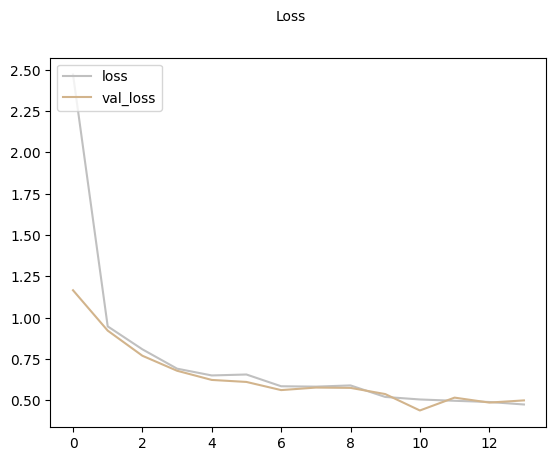

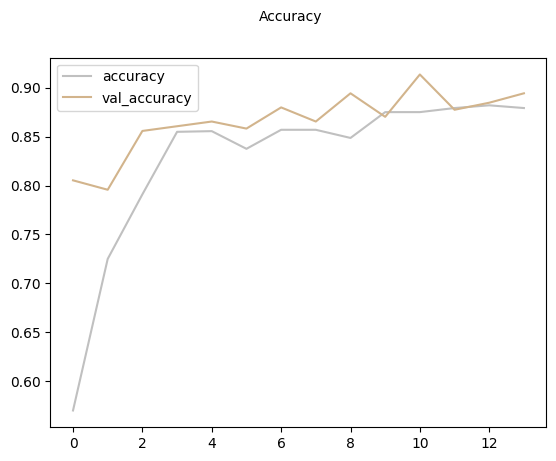

In [10]:
fig = plt.figure()
plt.plot(hist1.history['loss'], color='silver', label='loss')
plt.plot(hist1.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show()


fig = plt.figure()
plt.plot(hist1.history['accuracy'], color='silver', label='accuracy')
plt.plot(hist1.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="upper left")
plt.show()

In [13]:
model.save('/content/drive/MyDrive/Colab Notebooks/classification_real_ai.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model1.save('/content/drive/MyDrive/Colab Notebooks/classification_real_ai1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
